## homework 1


Homework 1:
Use this monthly rainfall data in Los Angeles available at the Bruinlearn (DJFLArainfall.txt) to determine:
1. Mean rainfall and confident interval during three consecutive winter months, December-February (DJF) in Los Angeles over the period of 1980-2018 at 95% confidence.

2. Test whether the DJF multi-year mean rainfall during the La Nina years (La Niña years, 1985, 1989, 1999; 2008, 2009, 2011) are significantly different from other years at 95% significance.
[Note: There are 38 (dec-Feb mean) samples, since the data starts from Dec1980-Feb1981 as the first sample, end in Dec2017-Feb2018). The La niña winters are 1985: Dec1984-Feb1985, 1989: Dec1988-Feb1989, 2008: Dec2007-Feb2008, and so on]

In [579]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import glob
from scipy.stats import norm
import os
import re
from datetime import datetime, timedelta
from haversine import haversine, Unit
import metpy
import metpy.constants as mpconst
import metpy.units as units
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
import statistics
from pydoc import help
%matplotlib inline
import warnings
import seaborn as sns
# warnings.filterwarnings("ignore")

In [581]:
djf = pd.read_csv('djfla_rainfall.txt', header = None, names=['rain'])

index = range(1980, 2018, 1)

djf.index = index

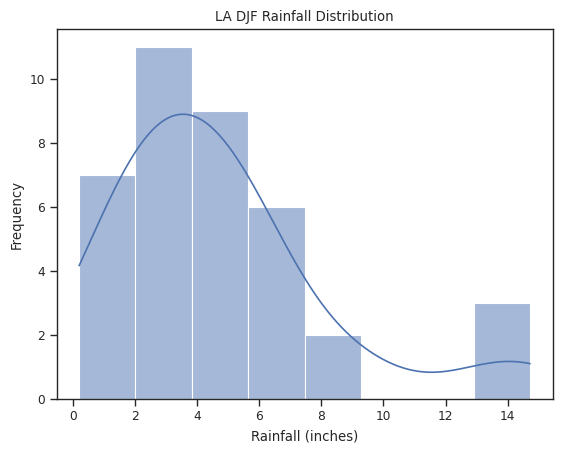

In [582]:
#appears to be gamma 

sns.histplot(djf['rain'], kde=True)

plt.title('LA DJF Rainfall Distribution')

plt.xlabel('Rainfall (inches)')

plt.ylabel('Frequency')

plt.show()

In [102]:
# lilliefors test to confirm not gaussian --> must be gamma

test_stat, p_value = sm.stats.lilliefors(djf['rain'], dist='norm')

print("K-S statisic:", test_stat)
print("p-value:", p_value)

K-S statisic: 0.16409832466691632
p-value: 0.01225685235407663


In [379]:
#calculating mean for gamma distribution 

x_bar = np.mean(djf['rain'])

ln_xbar = math.log(x_bar)

n = len(djf['rain'])

sum_lns = 0

for i in djf['rain']:
    
    j = math.log(i)
    
    sum_lns += j
    
D = ln_xbar - (sum_lns/n)

alpha = (1 + np.sqrt(1 + (4*D)/3))*(1/(4*D))

beta = x_bar/alpha

sample_mean = alpha*beta

print("sample mean:", sample_mean)

sample mean: 4.732368421052631


In [429]:
#why 1.96 for 95% confidence?

# margin = 1.96*(np.std(djf['rain']/np.sqrt(n)))

# confidence_interval = (sample_mean - margin, sample_mean + margin)

# print("confidence interval:", confidence_interval)

z = 1.96

var = alpha * (beta**2)

sigma = np.sqrt(var/n)

margin = z*(sigma/np.sqrt(n))

confidence_interval = (sample_mean - margin, sample_mean + margin)

print("confidence interval:", confidence_interval)

confidence interval: (4.552069853872689, 4.912666988232573)


In [417]:
#Welch's t-test: compares la nina years to non-la nina years

#to test the whether the two means are significantly different:

nina_yrs = [1984, 1988, 1998, 2007, 2008, 2010]

djf['nina'] = djf.index.isin(nina_yrs)

ninas = djf[djf['nina']==True]['rain']

non_ninas = djf[djf['nina']==False]['rain']

x1 = np.mean(ninas)

x2 = np.mean(non_ninas)

#variance: 
s1 = np.std(ninas)
var1 = s1**2

# var2 = statistics.variance(non_ninas)
s2 = np.std(non_ninas)
var2 = s2**2

N1 = len(ninas)

N2 = len(non_ninas)

# sigma = np.sqrt((N1*(s1**2) + N2*(s2**2))/(N1+N2-2))

t = (x1-x2)/np.sqrt(((var1)/N1) + ((var2)/N2))             
             
print("t value:", t)

print("degrees of freedom:", N1+N2-2)

print(t, "< 2.03 (threshold t value)"," therefore the null hypothesis can not be rejected with 95% confidence")


t value: -0.6391533544466788
degrees of freedom: 36
-0.6391533544466788 < 2.03 (threshold t value)  therefore the null hypothesis can not be rejected with 95% confidence


In [416]:
#the two variances are unequal, in particular s1/s2 < 0.5, so I must use a modified version of the test

print("La Nina years:")
print("mean (x1):", x1)
print("variance (s1):", s1**2)
print("")
print("Non La Nina years:")
print("mean (x2):", x2)
print("variance (s2):", s2**2)

print("s1/s2:",(s1**2)/(s2**2))

La Nina years:
mean (x1): 4.295
variance (s1): 1.317891666666667

Non La Nina years:
mean (x2): 4.814375
variance (s2): 14.101362109375
s1/s2: 0.09345846567478001


In [424]:
#degrees of freedom for welch's test

num = ( (s1**2)/N1 + (s2**2)/N2 )**2

denom = (s1**4)/((N1**2)*(N1-1)) + (s2**4)/((N2**2)*(N2-1))

deg_freedom = num/denom

t, deg_freedom 

(-0.6391533544466788, 27.39968551774873)

In [432]:
#welch's t-test using scipy

stats.ttest_ind(ninas.values, non_ninas.values, equal_var=False)

print("t =", abs(t), "< 2.05 (threshold t value for 36 degrees of freedom and 95% confidence), therefore the null hypothesis can not be rejected with 95% confidence") 



t = 0.6391533544466788 < 2.05 (threshold t value for 36 degrees of freedom and 95% confidence), therefore the null hypothesis can not be rejected with 95% confidence


## homework 2

1. Determine whether the probability distribution of the LA DJF rainfall is
Gaussian or Gamma distribution?
2. Test whether DJF mean and statistic distribution of the rainfall during the La
Nina years (La Niña years, 1985, 1989, 1999; 2008, 2009, 2011) are
significantly different from other years at 95% significance. Using Smirnov
two-sample test to determine whether the probability distribution of the
rainfall have the same distribution between La Niña years and other non-La
Niña years.
3. Test whether the statistical distribution of DJF rainfall in Los Angeles during
the La Nina years (1985, 1989, 2008, 2009, 2011) are significantly different
from other years at 95% significance using the Wilcoxon-Mann-Whitney
Test.

(You can use any codes or excel to calculate the results. However, you do not
need to show the codes, just briefly (1-2 sentences) describe the methods, the
formulas, the values for the key variables, plot PDF or CDF curves of the data
and parametric distributions (for q-1), and the final results. Then, provide a
few (1-3) sentences to answer the questions. For Q1: discuss the bin numbers
and widths you decide to use and explain the reasons behind your choice. For
q-2: show the ranked data and their CDF curves. For q-3, show R and U values
of each data and the critical values for 95% significance.)


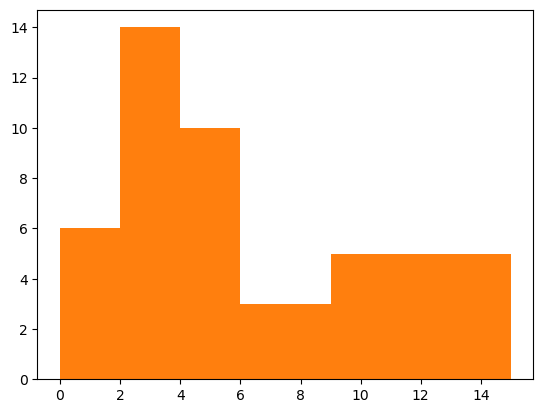

In [374]:
#choosing bins 

rainfall_data = djf['rain']

bins = [0, 2, 4, 6, 9, 15]

actual = plt.hist(djf['rain'], bins=bins)[0]

plt.hist(djf['rain'], bins=bins)

plt.show()

In [371]:
def calculate_midpoints(arr):
    
    midpoints = []
    
    for i in range(len(arr) - 1):
        
        midpoint = (arr[i] + arr[i + 1]) / 2.0
        
        midpoints.append(midpoint)
    
    return midpoints

In [468]:
bin_averages = calculate_midpoints(bins)

z = (bin_averages - np.mean(rainfall_data)) / np.std(rainfall_data)

#probability of z-scores using cdf
cdfs = stats.norm.cdf(z)

pdfs = stats.norm.pdf(z)

#expected given you fall within a certain bin  
expected = (cdfs - np.insert(np.delete(cdfs, 4), 0, 0)) * 38

chisquare = np.sum(((actual-expected) ** 2) / expected)

print(chisquare, "versus critical: 9.488")

14.95917448013446 versus critical: 9.488


In [471]:
cdfs

array([0.14182667, 0.30937076, 0.5306401 , 0.78669942, 0.98158652])

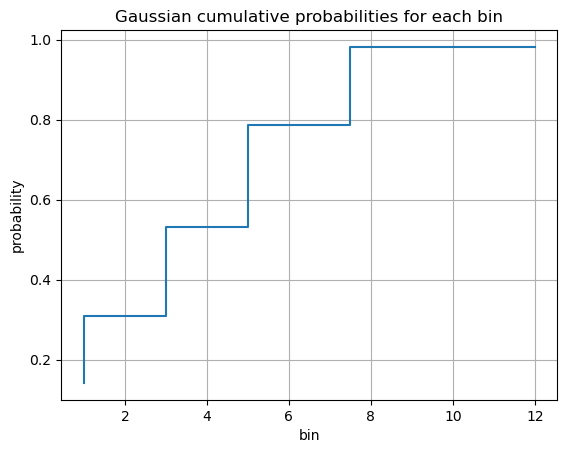

In [484]:
plt.step(bin_averages, cdfs)

plt.title('Gaussian cumulative probabilities for each bin')

plt.xlabel("bin")

plt.ylabel("probability")

plt.grid()

plt.show()

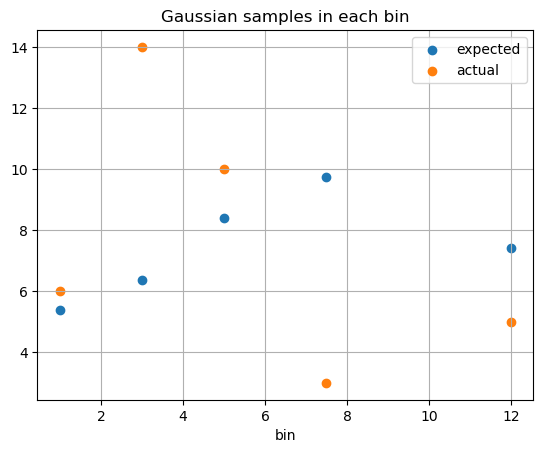

In [487]:
#expected versus actual samples in each bin 

plt.scatter(bin_averages, expected, label='expected')
plt.scatter(bin_averages, actual, label='actual')
plt.title("Gaussian samples in each bin")
plt.xlabel("bin")
plt.legend()
plt.grid()
plt.show()

In [377]:
#chi-square to test if gamma distribution

D = np.log(np.mean(rainfall_data) - np.mean(np.log(bin_averages)))

alpha = (1 + np.sqrt(1 + 4*D/3)) / (4*D)

beta = np.mean(rainfall_data) / alpha

gamma_variate = bin_averages / beta

cdfs_gamma = stats.gamma.cdf(gamma_variate, alpha)

expected_gamma = (cdfs_gamma - np.insert(np.delete(cdfs, 4), 0, 0)) * 38

chisquare_gamma = np.sum(((actual-expected_gamma) ** 2) / expected_gamma)

print(chisquare_gamma, "versus critical: 9.488")

10.11166193157689 versus critical: 9.488


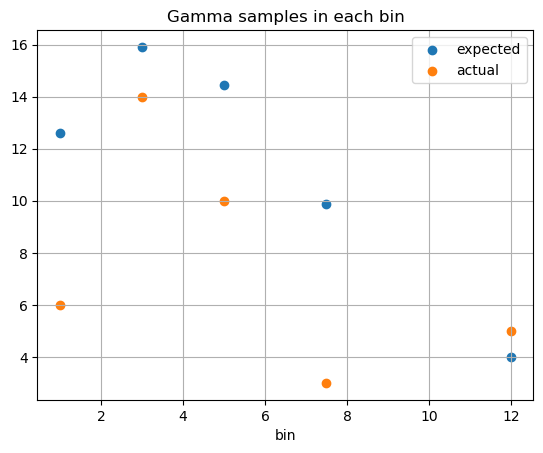

In [488]:
#expected versus actual samples in each bin 

plt.scatter(bin_averages, expected_gamma, label='expected')

plt.scatter(bin_averages, actual, label='actual')

plt.title("Gamma samples in each bin")

plt.legend()

plt.xlabel("bin")

plt.grid()

plt.show()

In [486]:
cdfs_gamma

array([0.33179336, 0.56052746, 0.68946273, 0.7908415 , 0.89178222])

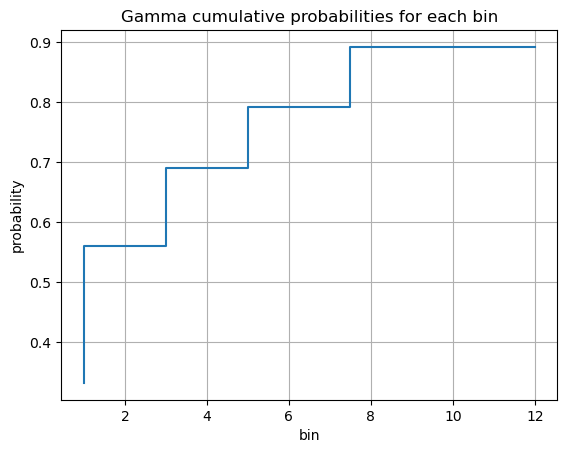

In [485]:
#gamma probabilities for each bin 

plt.step(bin_averages, cdfs_gamma)

plt.title('Gamma cumulative probabilities for each bin')

plt.xlabel("bin")

plt.ylabel("probability")

plt.grid()

plt.show()

In [242]:
#problem 2 = smirnov 2 sample test

n1 = len(ninas)

n2 = len(non_ninas)

print("Critical value Dsc =", np.sqrt(-0.5 * (1/n1 + 1/n2) * np.log(0.05/2)))

Critical value Dsc = 0.6041898399068719


In [264]:
print(stats.ks_2samp(non_ninas, ninas))

KstestResult(statistic=0.3020833333333333, pvalue=0.6567162232796907, statistic_location=3.61, statistic_sign=1)


In [335]:
#ranked data

ninas_ranked = ninas.sort_values().reset_index().reset_index()

ninas_ranked = ninas_ranked.rename(columns={'level_0': 'rank'})

ninas_ranked = ninas_ranked.rename(columns={'index': 'year'})

ninas_ranked['rank'] = ninas_ranked['rank']+1

#non-nina
non_ninas_ranked = non_ninas.sort_values().reset_index().reset_index()

non_ninas_ranked = non_ninas_ranked.rename(columns={'level_0': 'rank'})

non_ninas_ranked = non_ninas_ranked.rename(columns={'index': 'year'})

non_ninas_ranked['rank'] = non_ninas_ranked['rank']+1

non_ninas_ranked

,rank,year,rain
0,1,2011,0.20
1,2,2012,0.67
2,3,2006,0.98
3,4,2001,1.10
4,5,2013,1.10
5,6,2017,1.18
6,7,2015,2.00
7,8,2014,2.09
8,9,1983,2.10
9,10,1989,2.53


In [272]:
#1985, 1989, 1999; 2008, 2009, 2011)

np.mean(ninas), np.mean(non_ninas)

(4.295, 4.814375)

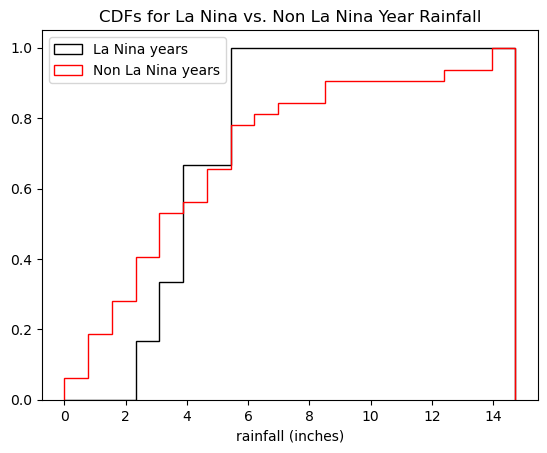

In [289]:
#cdfs

plt.hist(ninas, cumulative=True, bins=np.linspace(0, np.max(rainfall_data), 20), density=True, histtype='step', label="La Nina years", color='black')

plt.hist(non_ninas, cumulative=True, bins=np.linspace(0, np.max(rainfall_data), 20), density=True, histtype='step', label="Non La Nina years", color='red')

plt.legend(loc='upper left')

plt.title("CDFs for La Nina vs. Non La Nina Year Rainfall")

plt.xlabel("rainfall (inches)")

plt.show()

In [320]:
#ranking full df for wilcoxon-mann-whitney test

djf_ranked = djf.sort_values(by='rain').reset_index().reset_index()

djf_ranked = djf_ranked.rename(columns={'level_0': 'rank'})

djf_ranked = djf_ranked.rename(columns={'index': 'year'})

djf_ranked['rank'] = djf_ranked['rank'] + 1

In [326]:
ninas_wmw = djf_ranked[djf_ranked['nina']==True]

non_ninas_wmw = djf_ranked[djf_ranked['nina']==False]

In [329]:
n1 = len(ninas_wmw.values)

n2 = len(non_ninas_wmw.values)

R1 = np.sum(ninas_wmw['rank'])

R2 = np.sum(non_ninas_wmw['rank'])

U1 = R1 - (n1/2)*(n1+1)

U2 = R2 - (n2/2)*(n2+1)

print("La Nina Years:", "U1 =", U1, "R1 =", R1)
print("Non La Nina Years:", "U2 =", U2, "R2 =", R2)

La Nina Years: U1 = 105.0 R1 = 126
Non La Nina Years: U2 = 87.0 R2 = 615


In [331]:
m_u = (n1*n2)/2

sigma_u = np.sqrt((n1*n2)*(n1+n2+1)*(1/12))

z = (U2 - m_u)/sigma_u

print("z value:", z)

z value: -0.36028834606144605


In [333]:
p_value_two_tailed = 2 * stats.norm.cdf(z)  # Multiply by 2 for two-tailed test

# Calculate the p-value for a one-tailed test (lower tail)
p_value_one_tailed_lower = stats.norm.cdf(z)  # Lower tail test

print("P-value (two-tailed):", p_value_two_tailed) 

P-value (two-tailed): 0.7186315134575921


## homework 3

1. Use the same DJF rainfall in Los Angeles to determine whether there is a trend, if so, is it positive or negative, over the period of 1980-2018 using Mann-Kendall trend test for 95% confidence (or a=0.05).

2. Use the same DJF rainfall in Los Angeles used in homework 1 to determine
whether there is a trend in the rainfall data over the period of 1980-2018
using modified Mann-Kendall trend tests for 95% confidence (or a=0.05). If
so, is the trend positive or negative? (R code is provided at the CCLE course
website)

3. Applying the Vogelsang trend test to the same data as in question 1 to
determine whether there is a trend at 95% significance. (R code is provided
at the Bruinlearn AOS 219 website, in Week-4 Module)


(How to run Rcode in R-studio:
Open R-studio application
Import data: open “terminal”, drag the data file from Mac desktop to terminal
window, the path will automatically show up in terminal.
Copy the R code to the “console” window, hit the “return” button.)

(Note: Make sure to list the formulas used in your answer to each of the questions.
When you report your results, describe the trend and significance level. Compare
the results of questions 2 and 3 to that of question 1. Then briefly (1-2 sentences)
discuss whether the MMK or Vogelsang trend test is a more suitable trend test for
the data you have and why)


In [489]:
import pymannkendall as mk

In [522]:
#original mann-kendall test, does not assume autocorrelation

sign = np.empty(37)

for i in range(len(rainfall_data.values) - 1):
    
    sign[i] = np.sum(np.sign(rainfall_data.values[i+1:] - rainfall_data.values[i]))

S = np.sum(sign)

var_s = (38 * 37 * (2*38 + 5)) / 18

print("S:", S)

print("Var(s):", var_s)

S: -108.0
Var(s): 6327.0


In [524]:
z = (S+1) / np.sqrt(var_s)

print(z)

-1.3451938107550736


In [529]:
hamed_rao = mk.hamed_rao_modification_test(rainfall_data.values)

hamed_rao

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.17852833187966866, z=-1.3453001291753746, Tau=-0.15362731152204837, s=-108.0, var_s=6326.0, slope=-0.056296296296296296, intercept=4.921481481481481)

In [530]:
#assuming autocorrelation - Yue and Wang 2004

auto_mk = mk.yue_wang_modification_test(rainfall_data.values)

auto_mk

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='decreasing', h=True, p=0.00392133017123486, z=-2.8844218952532192, Tau=-0.15362731152204837, s=-108.0, var_s=1376.0999790100539, slope=-0.056296296296296296, intercept=4.921481481481481)

In [543]:
autocorr, conf = sm.tsa.acf(rainfall_data.values, nlags=len(rainfall_data.values), alpha=.05)

conf

array([[ 1.        ,  1.        ],
       [-0.35954959,  0.27634669],
       [-0.30243507,  0.33456079],
       [-0.26293388,  0.37422576],
       [-0.39977791,  0.23934384],
       [-0.15937377,  0.48380628],
       [-0.34421958,  0.31529657],
       [-0.25337997,  0.40626439],
       [-0.41914944,  0.24406728],
       [-0.53284122,  0.13503156],
       [-0.28053011,  0.4108814 ],
       [-0.49836119,  0.19553019],
       [-0.01393037,  0.69319527],
       [-0.37837209,  0.39189645],
       [-0.59658163,  0.17371092],
       [-0.44444987,  0.34896347],
       [-0.46456104,  0.33001316],
       [-0.54216187,  0.2547122 ],
       [-0.45748607,  0.34980201],
       [-0.42515317,  0.38358567],
       [-0.5418381 ,  0.2671167 ],
       [-0.54908704,  0.26924475],
       [-0.3190877 ,  0.50886166],
       [-0.4714501 ,  0.36088489],
       [-0.35274567,  0.48107275],
       [-0.392418  ,  0.44339457],
       [-0.40820045,  0.42792636],
       [-0.39943119,  0.43674267],
       [-0.36708728,

In [536]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(time_series)

print('ADF Statistic:', result[0])

print('p-value:', result[1])

print('Critical Values:')

for key, value in result[4].items():
    
    print(f'   {key}: {value}')

ADF Statistic: -6.092869856287819
p-value: 1.0264557314996565e-07
Critical Values:
   1%: -3.6209175221605827
   5%: -2.9435394610388332
   10%: -2.6104002410518627


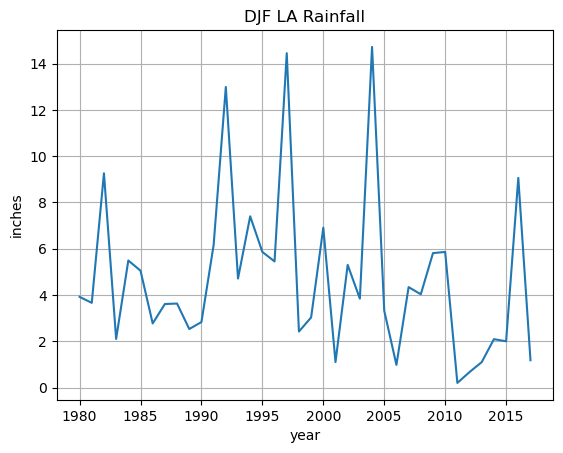

In [541]:
plt.plot(rainfall_data)
plt.title("DJF LA Rainfall")
plt.xlabel("year")
plt.ylabel("inches")
plt.grid()
plt.show()

## Homework 4

1. Determine the field significance between the December-February (DJF) 500
hPa geopotential height anomalies over the North America and DJF El Niño index
using FDR test for the period of 1950-2018. The 500 hPa geopotential height data
are available at Bruinlearn (They can be extracted from data available at
https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.pressure.html,
“monthly mean” geopotential height, “hgt.mon.mean.nc”) and Nino 3.4 can be
download from
https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Data/nino34.long.anom.da
ta).


In [558]:
import numpy as np

import pandas as pd

from netCDF4 import Dataset

from scipy.stats import norm,binom,t,pearsonr

import iris

import iris.coord_categorisation

#===============================================================================
# used for creating plots
import matplotlib.pyplot as plt

import seaborn as sns
# mapping tools from cartopy
import cartopy.crs as ccrs

import cartopy.feature as cfeat

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#===============================================================================
# read in hgt using Iris

hgt = iris.load('hgt.mon.mean.500hPa.nc')[0]

lons = np.array(hgt.coord('longitude').points)

lats = np.array(hgt.coord('latitude').points)

# constraints (space: North America; time: 1950-2018)
nala = lambda cell: 10 <= cell <= 90

nalc = lambda cell: 180 <= cell <= 310

sclm = lambda cell: 1950 <= cell <= 2018

# load 500 hPa hgt data
hgt = iris.load('hgt.mon.mean.500hPa.nc',
                iris.Constraint(coord_values={'latitude':nala,'longitude':nalc}))[0]

# extract 1950-2018 
iris.coord_categorisation.add_year(hgt, 'time', name='year')

hgtn = hgt.extract(iris.Constraint(coord_values={'year':sclm}))

lons = np.array(hgt.coord('longitude').points)

lats = np.array(hgt.coord('latitude').points)

hgtd = np.squeeze(hgtn.data)

In [559]:
# DJF hgt
h12 = hgtd[11::12]

h01 = hgtd[12::12] # start from second January to match first December

h02 = hgtd[13::12]

hdjf = (h12+h01+h02)/3.  

yrs = np.arange(1950,2018,1)

# calculate anomaly
hanm = np.empty(hdjf.shape)

for ii in range(len(yrs)): 
    
    hanm[ii,:] = hdjf[ii,:] - hdjf.mean(axis=0)

In [560]:
#===============================================================================
# read in Nino34 during 1950-2018
nino = pd.read_csv('nino34.long.anom.data.txt',header=None,skiprows=1,delim_whitespace=True)[1950-1870:2018-1870+1]

# DJF rainfall over the period of 1950-2018, DJF starts from December 1950
nino12 = (nino.iloc[:,12].values).astype(float)[:-1]

nino01 = (nino.iloc[:,1].values).astype(float)[1:]

nino02 = (nino.iloc[:,2].values).astype(float)[1:]

ninodjf = (nino12+nino01+nino02)/3.

In [561]:
#===============================================================================
# calculate the correlation between DJF hgt anomaly and DJF nino3.4
corr = np.zeros([len(lats),len(lons)])

prob = np.zeros([len(lats),len(lons)])

for ii in range(len(lons)):
    
    for jj in range(len(lats)):
        
        corr[jj,ii], prob[jj,ii] = pearsonr(hanm[:,jj,ii],ninodjf)

In [570]:
probr.shape, prob.shape

((1749,), (33, 53))

In [571]:
33*53

1749

717 The global null hypothesis can be rejected.


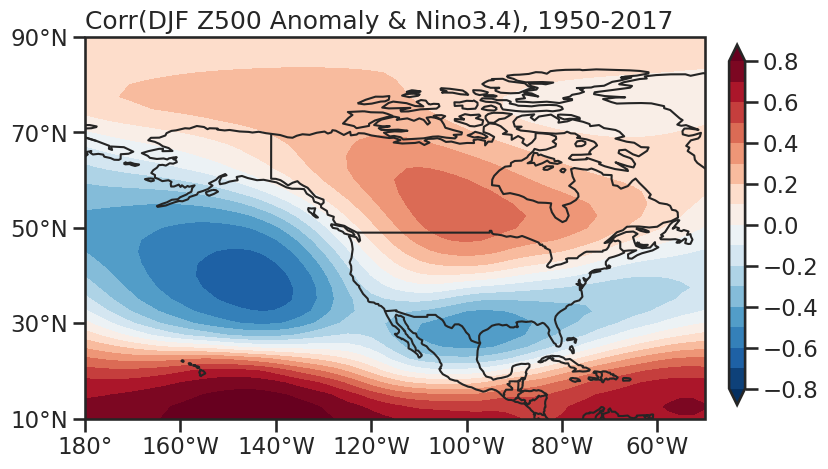

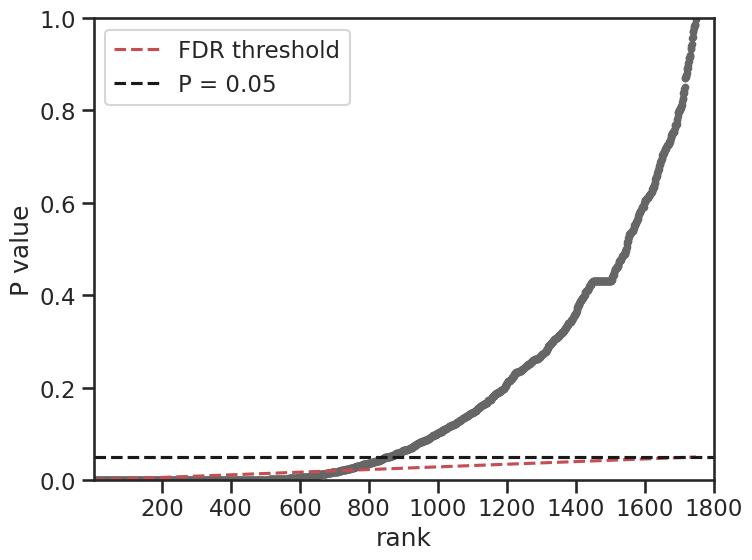

In [566]:
# plot parameters
sns.set(style='ticks', context='talk')

xfr = LongitudeFormatter(zero_direction_label=True)

yfr = LatitudeFormatter()

# contour level
ll = -0.8; uu = 0.8; nn=17

clv = np.linspace(ll,uu,nn)

fig1 = plt.figure(figsize=(8, 6))

axs = fig1.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

cs0 = axs.contourf(lons, lats, corr, clv, cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree())

axs.set_title(u'Corr(DJF Z500 Anomaly & Nino3.4), 1950-2017',loc='left')

axs.set_extent([180, 310, 10, 90],ccrs.PlateCarree())

axs.set_xticks(range(180, 311, 20), crs=ccrs.PlateCarree())

axs.set_yticks(range(10, 91, 20), crs=ccrs.PlateCarree())

axs.xaxis.set_major_formatter(xfr)

axs.yaxis.set_major_formatter(yfr)

axs.add_feature(cfeat.COASTLINE, edgecolor='#252525')

axs.add_feature(cfeat.BORDERS, edgecolor='#252525')

cax = fig1.add_axes([0.93, 0.2, 0.02, 0.6])

cb0 = fig1.colorbar(cs0, cax=cax, orientation='vertical')

# cb0.set_ticks([np.linspace(ll,uu,nn)])

cb0.outline.set_visible(True)

cb0.set_label(r'')

plt.savefig('correlation.pdf',bbox_inches='tight')

##===============compare to the FDR threshold====================================
probr = np.sort(prob.flatten())   

alphag = 0.05

nb = len(lats)*len(lons) ## 53*33 = 1749

Pfdr = np.zeros(probr.shape)

for ii in range(nb-1,-1,-1):
    
    Pfdr[ii] = alphag*(ii+1)/nb

# plot
fig2 = plt.figure(figsize=(8,6))

ax1 = fig2.add_subplot(111)

ax1.plot(np.arange(1,nb+1),probr,'.',color='#666666') 

ax1.plot(np.arange(1,nb+1),Pfdr,'--',color='r', label='FDR threshold')

ax1.axhline(0.05, linestyle='--', color='k', label='P = 0.05')

ax1.set_xlim(1,1800)

ax1.set_ylim(0.0,1)

ax1.set_xlabel('rank')

ax1.set_ylabel('P value')

ax1.legend(fancybox=True,loc=2)

plt.savefig('fdr.pdf', bbox_inches='tight')

i = nb-1

while i < nb:
    
    if probr[i] > Pfdr[i]:
        
        i = i-1
        
        sig = 'The global null hypothesis cannot be rejected.'
        
        continue
    
    else:
        
        sig = 'The global null hypothesis can be rejected.'
        
        break
    
print (i,sig) 
## 'The global null hypothesis can be rejected.' 
## Prob(717) < Pfdr(717)

## homework 5 

Determine the leading 2 EOF modes of the sea surface temperatures
anomalies (SSTA) during December-February season mean for the period of 1854 -
2019 using EOF, Varimax rotated EOF and CEOF, respectively. The data file,
sst.mnmean.v4.nc, is available at Bruinlearn under “Week 7”. The dimension of the
file is 180 Lon X 89 Lat, including every month during Jan. 1854-Apr 2019. (Make sure
to fully update the netCDF4 package. Also, google the specific error message to help you find
solution to resolve the error.)

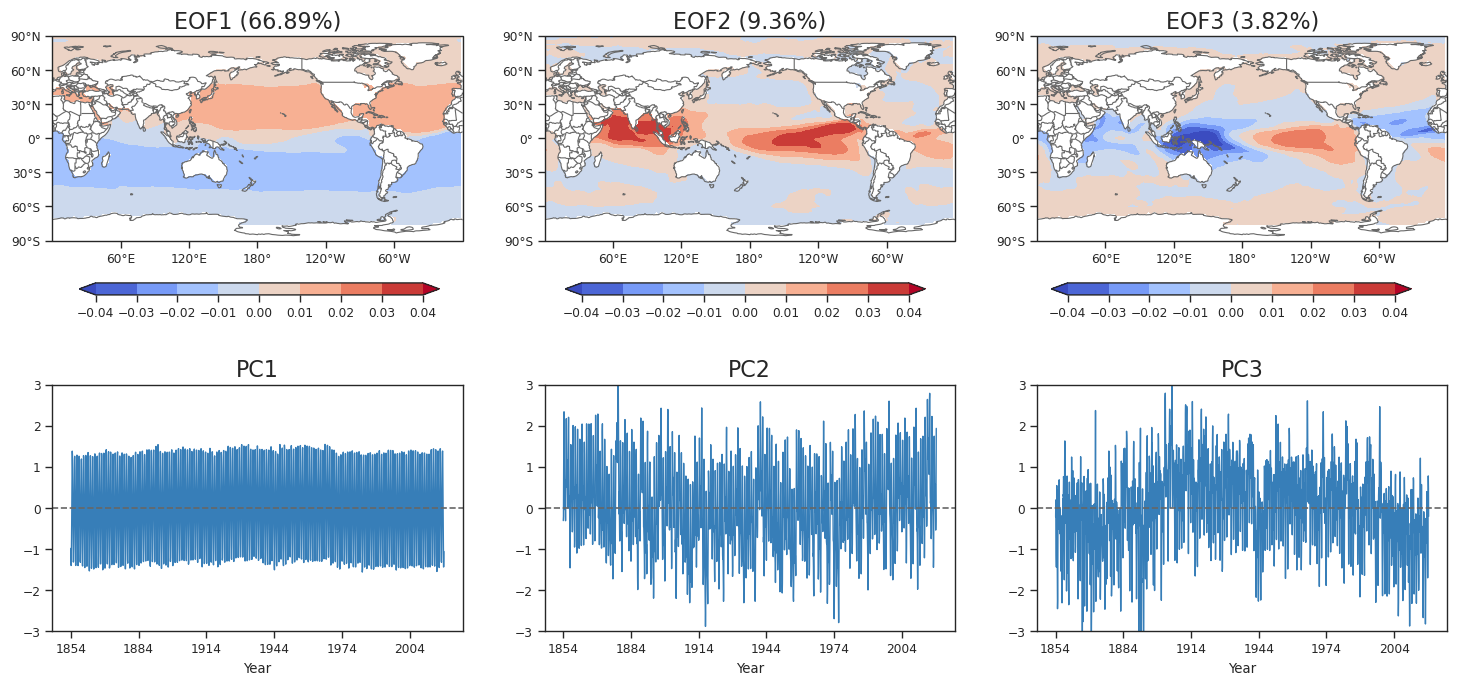

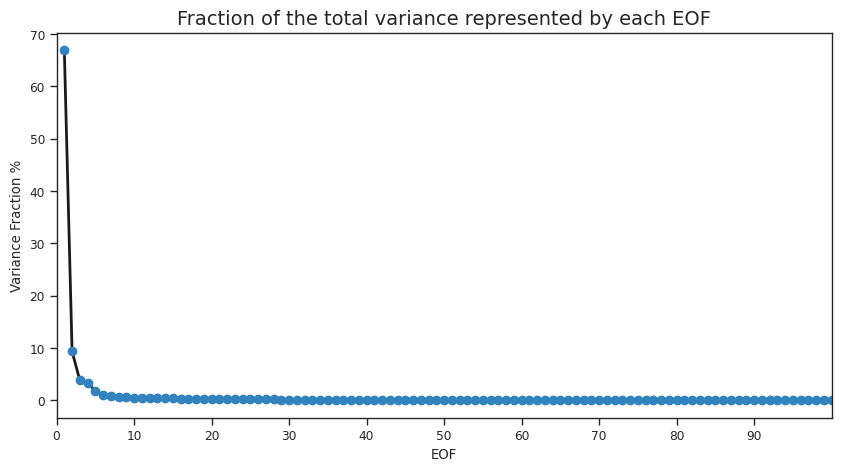

In [576]:
import numpy as np
import scipy
import scipy.io
from eofs.standard import Eof
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeat
# from eofs_func import Detrend
from regressionutils import Detrend

# directory
# ddir = '/home/achang1029/Misc Files/'

#------------------------------------------------------------------------------
# read in sst data
lats = Dataset('sst.mnmean.v4.nc')['lat'][:]
lons = Dataset('sst.mnmean.v4.nc')['lon'][:]
ssta = Dataset('sst.mnmean.v4.nc')['sst'][:]

#years
yrs = np.arange(1854,2019.33,1/12)

# detrend 
ssta_dt = np.empty(ssta.shape)
for yy in range(len(lats)):
    for xx in range(len(lons)):
        ssta_dt[:,yy,xx] = Detrend(yrs, ssta[:,yy,xx])

# mask
ssta_dt = np.ma.masked_invalid(ssta_dt)

# normalize
ssta_dt = (ssta_dt - ssta_dt.mean(axis =0))/ssta_dt.std(axis =0)

#------------------------------------------------------------------------------
# apply EOF
wgts   = np.cos(np.deg2rad(lats))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(ssta_dt, weights=wgts)

eofs = solver.eofs(neofs=3)
pcs  = solver.pcs(npcs=3, pcscaling=1)  
vfrc = solver.varianceFraction()
        
#------------------------------------------------------------------------------
# plot
sns.set(style='ticks', context='paper')

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.04; uu = 0.04
clev = np.linspace(ll,uu,9)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofs[0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('EOF1 ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs,pcs[:, 0], color='#377eb8', linewidth=1)
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-3,3)
ax2.set_xlabel('Year')

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofs[1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('EOF2 ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs,pcs[:, 1], color='#377eb8', linewidth=1)
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-3,3)
ax4.set_xlabel('Year')

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofs[2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('EOF3 ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs,pcs[:, 2], color='#377eb8', linewidth=1)
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-3,3)
ax6.set_xlabel('Year')
plt.show()

fig1 = plt.figure(figsize=(10, 5))
axs = fig1.add_subplot(111)
eof_num = np.arange(1,vfrc.shape[0]+1)
axs.plot(eof_num, vfrc*100, linewidth=2,color='k')
axs.plot(eof_num, vfrc*100, linestyle='None', marker="o", color='#3182bd', markersize=6)
axs.set_title('Fraction of the total variance represented by each EOF', fontsize=14)
axs.set_xlabel('EOF')
axs.set_ylabel('Variance Fraction %')
axs.set_xlim(0, 100)
axs.set_xticks(range(0, 100, 10))
axs.set_xticklabels(np.arange(0, 100, 10).astype('int').astype('str'))
plt.show()


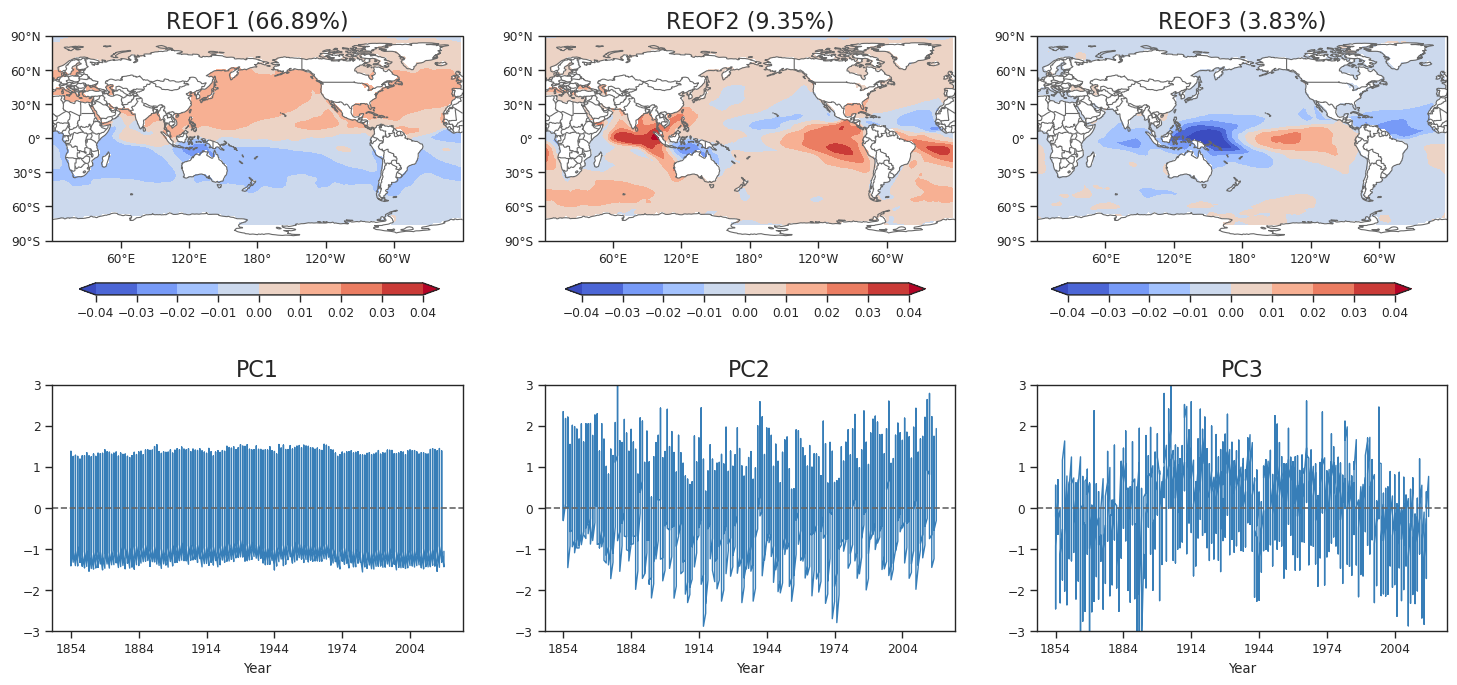

In [577]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

# import numpy as np
# import scipy
# import scipy.io
# import seaborn as sns
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.feature as cfeat
# from eofs.standard import Eof
# # from eofs_func import Detrend
# from regressionutils import Detrend

# directory
# ddir = '/home/achang1029/Misc Files/'

#------------------------------------------------------------------------------
# read in sst data
lats = Dataset('sst.mnmean.v4.nc')['lat'][:]
lons = Dataset('sst.mnmean.v4.nc')['lon'][:]
ssta1 = Dataset('sst.mnmean.v4.nc')['sst'][:]


# years
yrs = np.arange(1854,2019.33,1/12).astype('int')

# detrend 
ssta_dt = np.empty(ssta.shape)
for yy in range(len(lats)):
    for xx in range(len(lons)):
        ssta_dt[:,yy,xx] = Detrend(yrs, ssta[:,yy,xx])

# mask
ssta_dt = np.ma.masked_invalid(ssta_dt)

# normalize
ssta_dt = (ssta_dt - ssta_dt.mean(axis =0))/ssta_dt.std(axis =0)

#------------------------------------------------------------------------------
# apply EOF
wgts   = np.cos(np.deg2rad(lats))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(ssta_dt, weights=wgts)

eofs = solver.eofs(neofs=5)
pcs  = solver.pcs(npcs=5, pcscaling=1)  
vfrc = solver.varianceFraction(neigs=5)

# the first 5 eofs are selected to do varimax rotation

def varimax_rotation(x, eps=1e-10, itermax=100):
    """
    Rotate EOFs according to varimax algorithm

    Variables:
    x :: a matrix of EOFs (one column for each EOF)
    R :: rotation matrix
    y :: new EOFs (new_EOFs =EOFs*R)
    
    """
    nrow, ncol = x.shape
    R = np.eye(ncol)
    var = 0

    for ii in range(itermax):
        x_rot = np.dot(x, R)
        tmp = np.diag(np.sum(x_rot ** 2, axis=0)) / nrow 
        u, s, v = np.linalg.svd(np.dot(x.T, x_rot ** 3 - np.dot(x_rot, tmp)))
        R = np.dot(u, v)
        var_new = np.sum(s)
        if var_new < var * (1 + eps):
            print ("varimax done in ", ii , " iteration")
            break
        var = var_new
        
    y = np.dot(x,R)

    return y,R

# preprocess SSTA
nb, nlat_sst, nlon_sst = eofs.shape
eofs2d = np.reshape(eofs, (nb, nlat_sst*nlon_sst), order='F')
eofs2dt = np.transpose(eofs2d, (1, 0))

nonMissingIndex = np.where(np.isnan(eofs2dt[:,0]) == False)[0]
eofs2dtNoMissing = eofs2dt[nonMissingIndex,: ]

# apply varimax rotation
eofs_r,matrix_r = varimax_rotation(eofs2dtNoMissing)

# reshape rotated EOFs
eofs_rtr = np.ones([nlat_sst*nlon_sst,nb]) * np.NaN
eofs_rtr = eofs_rtr.astype(eofs_r.dtype)
eofs_rtr[nonMissingIndex,:] = eofs_r[:,:]
eofs_rtr = eofs_rtr.reshape([nlat_sst,nlon_sst,nb], order='F')

#------------------------------------------------------------------------------
# plot
sns.set(style='ticks', context='paper')

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.04; uu = 0.04
clev = np.linspace(ll,uu,9)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofs_rtr[:,:,0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('REOF1 ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
# ax1.set_title('REOF1', fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs,pcs[:, 0], color='#377eb8', linewidth=1)
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-3,3)
ax2.set_xlabel('Year')

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofs_rtr[:,:,1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('REOF2 ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
# ax3.set_title('REOF2', fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs,pcs[:, 1], color='#377eb8', linewidth=1)
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-3,3)
ax4.set_xlabel('Year')

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofs_rtr[:,:,2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('REOF3 ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
# ax5.set_title('REOF3', fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs,pcs[:, 2], color='#377eb8', linewidth=1)
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-3,3)
ax6.set_xlabel('Year')

plt.show()


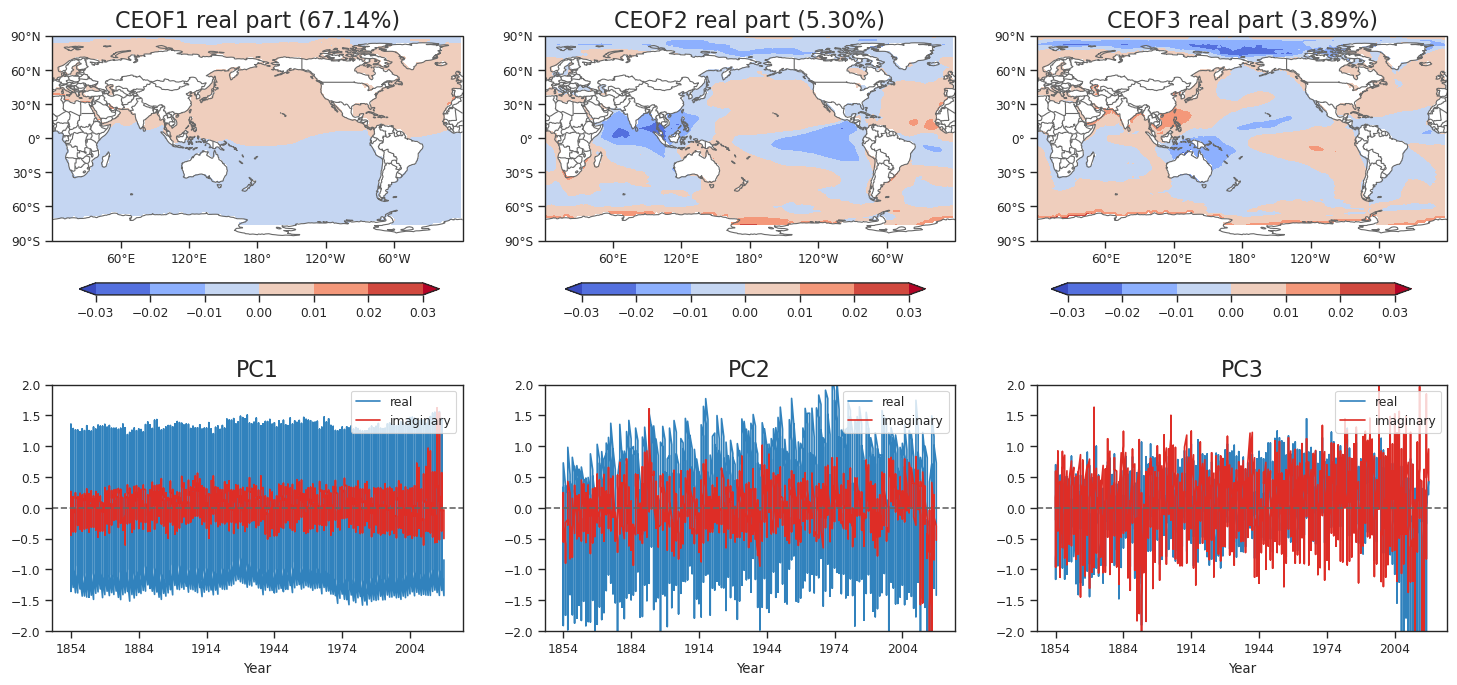

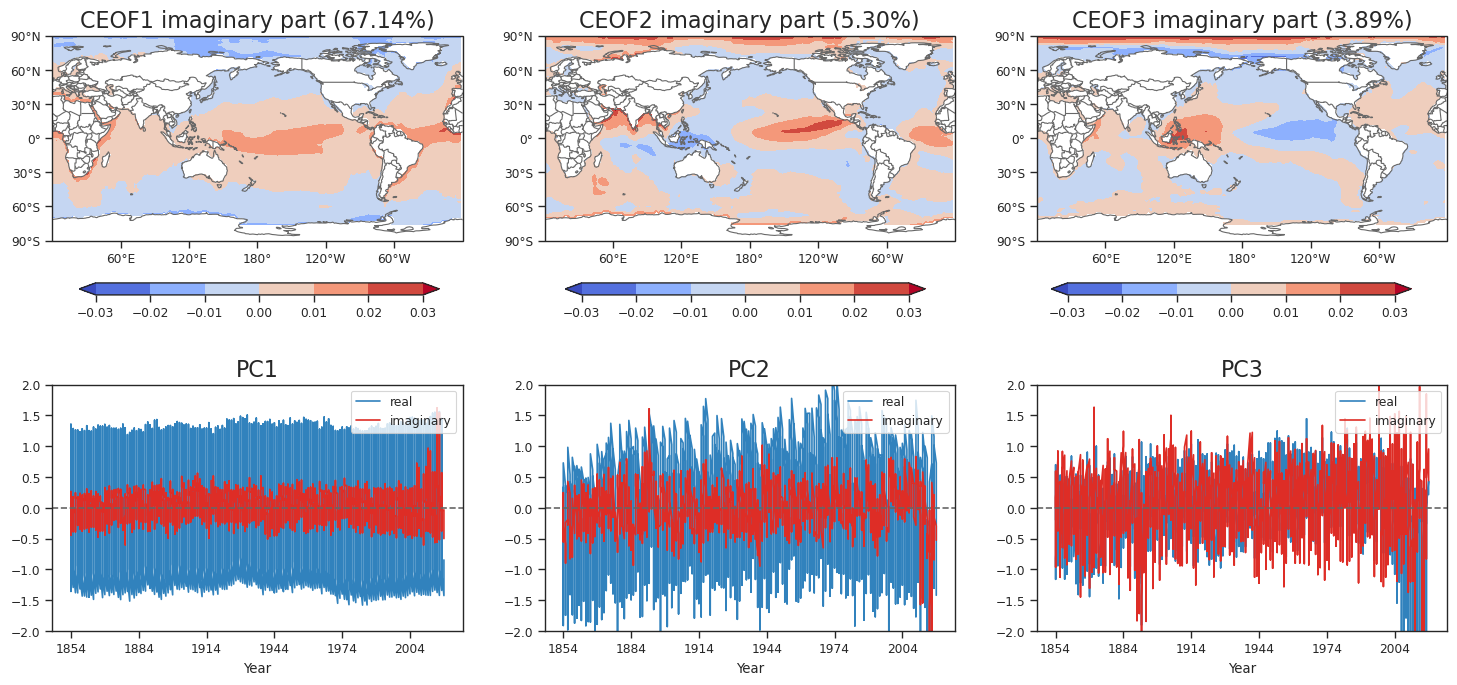

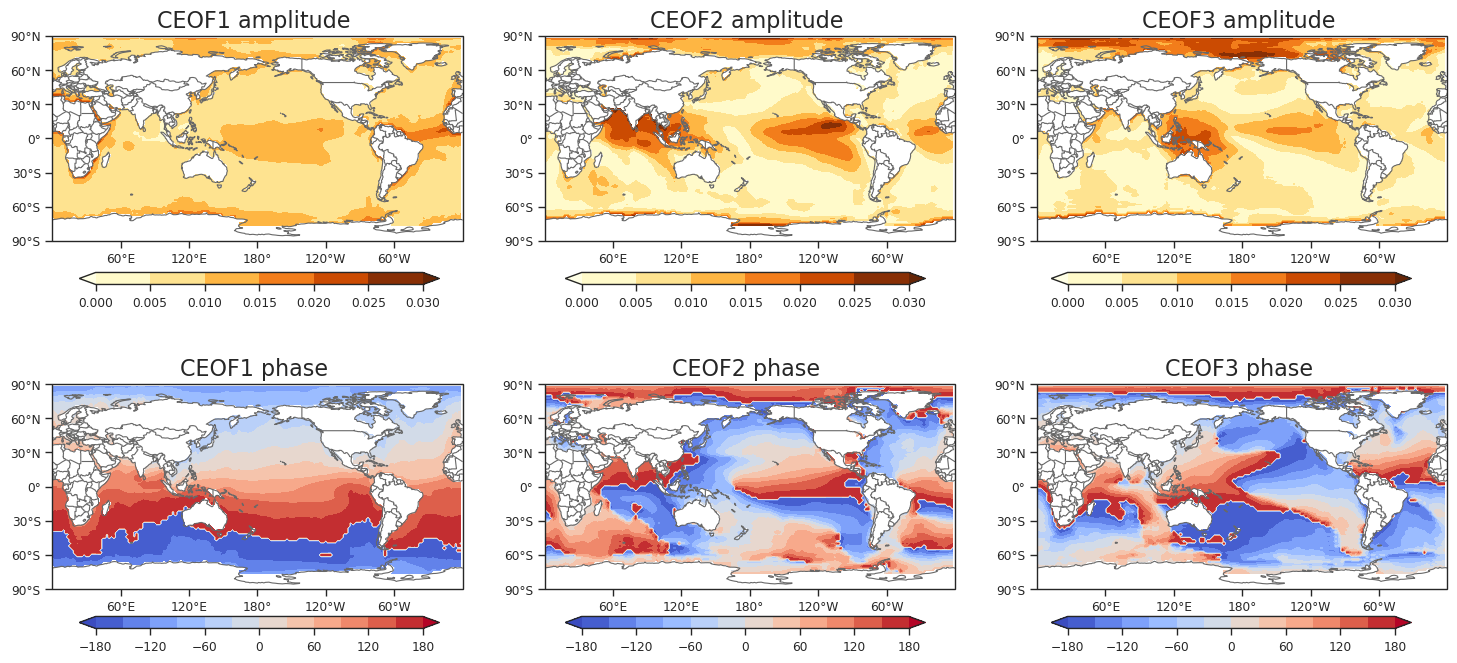

/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/annierosen16/anaconda3/envs/annieenv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(v

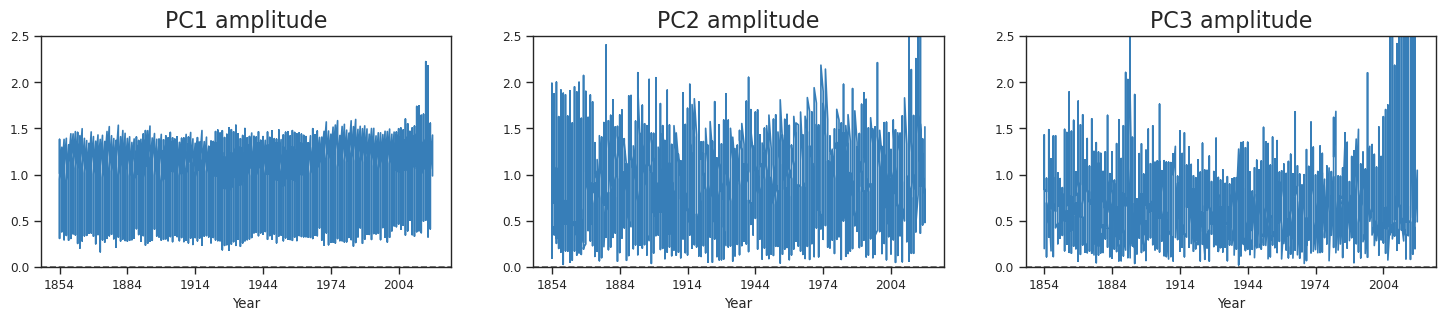

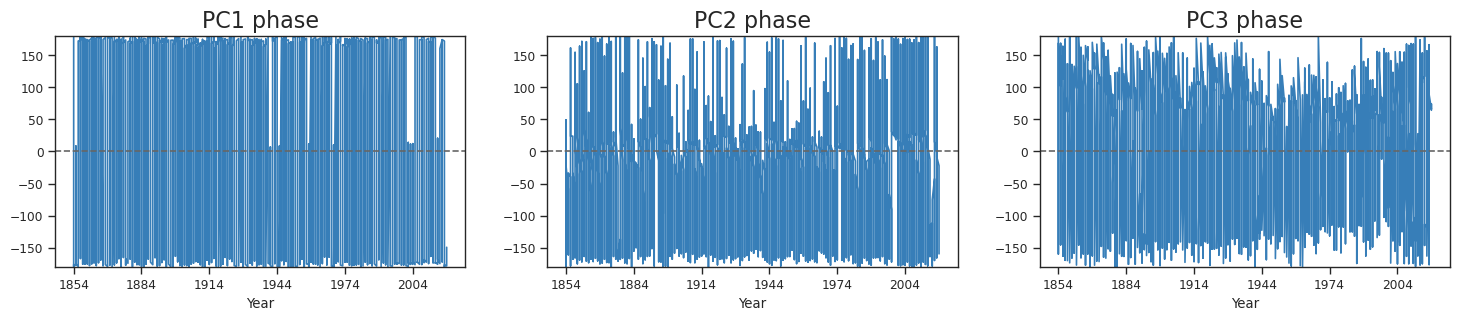

In [583]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

import numpy as np
import scipy
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeat
from eofs.standard import Eof
from scipy.signal import hilbert
import math
# from eofs_func import Detrend
from regressionutils import Detrend

# directory
# ddir = '/home/achang1029/Misc Files/'

#------------------------------------------------------------------------------
# read in sst data
lats = Dataset('sst.mnmean.v4.nc')['lat'][:]
lons = Dataset('sst.mnmean.v4.nc')['lon'][:]
ssta1 = Dataset('sst.mnmean.v4.nc')['sst'][:]

# years
yrs = np.arange(1854,2019.33,1/12).astype('int')

# detrend 
ssta_dt = np.empty(ssta.shape)
for yy in range(len(lats)):
    for xx in range(len(lons)):
        ssta_dt[:,yy,xx] = Detrend(yrs, ssta[:,yy,xx])

# mask
ssta_dt = np.ma.masked_invalid(ssta_dt)

# normalize
ssta_dt = (ssta_dt - ssta_dt.mean(axis =0))/ssta_dt.std(axis =0)

# proprocess SST
ntime, nlat_sst, nlon_sst = ssta_dt.shape
sst2d = np.reshape(ssta_dt, (ntime, nlat_sst*nlon_sst), order='F')

nonMissingIndex = np.where(np.isnan(sst2d[0]) == False)[0]
sst2dNoMissing = sst2d[:, nonMissingIndex]

# hilbert transform
sst2dh = hilbert(sst2dNoMissing)
#sst_real = np.real(hilbert(sst2dNoMissing))
#sst_img = np.imag(hilbert(sst2dNoMissing))

#------------------------------------------------------------------------------
# apply EOF
wgts   = np.cos(np.deg2rad(lats))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(sst2dh, weights=wgts)

eofs = solver.eofs(neofs=3)
#eofs = solver.eofsAsCovariance(neofs=3)
pcs  = solver.pcs(npcs=3, pcscaling=1)  
vfrc = solver.varianceFraction(neigs=3)

# eofs
eofs_real = np.real(eofs)
eofs_imag = np.imag(eofs)

# pcs
pcs_r = np.real(pcs)
pcs_i = np.imag(pcs)

# spatial amplitude
eofs_am = np.power(eofs*np.conjugate(eofs), 0.5)
eofs_am = np.real(eofs_am)
# spatial phase
eofs_ph = np.arctan2(eofs_imag,eofs_real)
eofs_ph = eofs_ph*180./math.pi
# temporal amplitude
Rt = np.power(pcs*np.conjugate(pcs), 0.5)
# temporal phase
pht = np.arctan2(pcs_i,pcs_r)
pht = pht*180./math.pi

# reshape real and imaginary part of eof, amplitude and phase
eofsn_r = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofsn_r = eofsn_r.astype(eofs_real.dtype)

eofsn_i = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofsn_i = eofsn_i.astype(eofs_imag.dtype)

eofs_amr = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofs_amr = eofs_amr.astype(eofs_am.dtype)

eofs_phr = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofs_phr = eofs_phr.astype(eofs_ph.dtype)

for ii in range(3):
    eofsn_r[ii,nonMissingIndex] = eofs_real[ii,:]
    eofsn_i[ii,nonMissingIndex] = eofs_imag[ii,:]
    eofs_amr[ii,nonMissingIndex] = eofs_am[ii,:]
    eofs_phr[ii,nonMissingIndex] = eofs_ph[ii,:]
    
eofsn_r = eofsn_r.reshape([3,nlat_sst,nlon_sst], order='F')
eofsn_i = eofsn_i.reshape([3,nlat_sst,nlon_sst], order='F')
eofs_amr = eofs_amr.reshape([3,nlat_sst,nlon_sst], order='F')
eofs_phr = eofs_phr.reshape([3,nlat_sst,nlon_sst], order='F')

#------------------------------------------------------------------------------
# plot parameter
sns.set(style='ticks', context='paper')


#------------------------------------------------------------------------------
# plot real part and PCs
# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.03; uu = 0.03
clev = np.linspace(ll,uu,7)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofsn_r[0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('CEOF1 real part ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofsn_r[1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('CEOF2 real part ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')

cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofsn_r[2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('CEOF3 real part ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs, pcs_r[:,0], color = '#3182bd', label='real')
ax2.plot(yrs, pcs_i[:,0], color = '#de2d26', label='imaginary')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-2,2)
ax2.set_xlabel('Year')
ax2.legend(fancybox=True,loc=1)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs, pcs_r[:,1], color = '#3182bd', label='real')
ax4.plot(yrs, pcs_i[:,1], color = '#de2d26', label='imaginary')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-2,2)
ax4.set_xlabel('Year')
ax4.legend(fancybox=True,loc=1)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs, pcs_r[:,2], color = '#3182bd', label='real')
ax6.plot(yrs, pcs_i[:,2], color = '#de2d26', label='imaginary')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-2,2)
ax6.set_xlabel('Year')
ax6.legend(fancybox=True,loc=1)

plt.show()

#------------------------------------------------------------------------------
## plot imaginary part and PCs

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.03; uu = 0.03
clev = np.linspace(ll,uu,7)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofsn_i[0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('CEOF1 imaginary part ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofsn_i[1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('CEOF2 imaginary part ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')

cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofsn_i[2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('CEOF3 imaginary part ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs, pcs_r[:,0], color = '#3182bd', label='real')
ax2.plot(yrs, pcs_i[:,0], color = '#de2d26', label='imaginary')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-2,2)
ax2.set_xlabel('Year')
ax2.legend(fancybox=True,loc=1)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs, pcs_r[:,1], color = '#3182bd', label='real')
ax4.plot(yrs, pcs_i[:,1], color = '#de2d26', label='imaginary')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-2,2)
ax4.set_xlabel('Year')
ax4.legend(fancybox=True,loc=1)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs, pcs_r[:,2], color = '#3182bd', label='real')
ax6.plot(yrs, pcs_i[:,2], color = '#de2d26', label='imaginary')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-2,2)
ax6.set_xlabel('Year')
ax6.legend(fancybox=True,loc=1)

plt.show()


#------------------------------------------------------------------------------
## plot spatial amplitude and phase

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.3)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = 0.; uu = 0.03
clev = np.linspace(ll,uu,7)
clev2 = np.linspace(-180,180,13)

# EOF1 amplitude
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofs_amr[0], clev, cmap=plt.cm.YlOrBr, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('CEOF1 amplitude ', fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# EOF2 amplitude
ax2 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs2 = ax2.contourf(lons,lats, eofs_amr[1], clev, cmap=plt.cm.YlOrBr, extend='both', transform=ccrs.PlateCarree())
ax2.set_title('CEOF2 amplitude ', fontsize=16)
ax2.set_extent([-180, 180, -90, 90])
ax2.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax2.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax2.xaxis.set_major_formatter(xfr)
ax2.yaxis.set_major_formatter(yfr)
ax2.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax2.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs2, cax=cax2, orientation='horizontal')
cb2.outline.set_visible(True)

# EOF3 amplitude
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofs_amr[2], clev, cmap=plt.cm.YlOrBr, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('CEOF3 amplitude ', fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb3 = fig.colorbar(cs3, cax=cax3, orientation='horizontal')
cb3.outline.set_visible(True)

# EOF1 phase
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180))
cs4 = ax4.contourf(lons,lats, eofs_phr[0], clev2, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax4.set_title('CEOF1 phase ', fontsize=16)
ax4.set_extent([-180, 180, -90, 90])
ax4.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax4.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax4.xaxis.set_major_formatter(xfr)
ax4.yaxis.set_major_formatter(yfr)
ax4.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax4.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax4 = fig.add_axes([0.14, 0.1, 0.2, 0.015])
cb4 = fig.colorbar(cs4, cax=cax4, orientation='horizontal')
cb4.outline.set_visible(True)


# EOF2 phase
ax5 = fig.add_subplot(235, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofs_phr[1], clev2, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('CEOF2 phase ', fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax5 = fig.add_axes([0.41, 0.1, 0.2, 0.015])
cb5 = fig.colorbar(cs5, cax=cax5, orientation='horizontal')
cb5.outline.set_visible(True)

# EOF3 phase
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180))
cs6 = ax6.contourf(lons,lats, eofs_phr[2], clev2, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax6.set_title('CEOF3 phase ', fontsize=16)
ax6.set_extent([-180, 180, -90, 90])
ax6.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax6.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax6.xaxis.set_major_formatter(xfr)
ax6.yaxis.set_major_formatter(yfr)
ax6.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax6.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax6 = fig.add_axes([0.68, 0.1, 0.2, 0.015])
cb6 = fig.colorbar(cs6, cax=cax6, orientation='horizontal')
cb6.outline.set_visible(True)

plt.show()

#------------------------------------------------------------------------------
# plot temporal pcs

# MAPS
fig = plt.figure(figsize=(18, 3))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# PC1               
ax2 = fig.add_subplot(131)
ax2.plot(yrs, Rt[:,0], color = '#377eb8')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1 amplitude', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(0,2.5)
ax2.set_xlabel('Year')

# PC2 
ax4 = fig.add_subplot(132)
ax4.plot(yrs, Rt[:,1], color = '#377eb8')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2 amplitude', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(0,2.5)
ax4.set_xlabel('Year')

# PC3 
ax6 = fig.add_subplot(133)
ax6.plot(yrs, Rt[:,2], color = '#377eb8')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3 amplitude', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(0,2.5)
ax6.set_xlabel('Year')

plt.show()


#------------------------------------------------------------------------------
# plot temporal phase

# MAPS
fig = plt.figure(figsize=(18, 3))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# PC1               
ax2 = fig.add_subplot(131)
ax2.plot(yrs, pht[:,0], color = '#377eb8')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1 phase', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-180,180)
ax2.set_xlabel('Year')

# PC2 
ax4 = fig.add_subplot(132)
ax4.plot(yrs, pht[:,1], color = '#377eb8')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2 phase', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-180,180)
ax4.set_xlabel('Year')

# PC3 
ax6 = fig.add_subplot(133)
ax6.plot(yrs, pht[:,2], color = '#377eb8')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3 phase', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-180,180)
ax6.set_xlabel('Year')

plt.show()
